<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>
Автор материала: Юрий Кашницкий, программист-исследователь Mail.Ru Group <br> 

Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание 6 (демо). Линейная регрессия, Lasso и RF-регрессия в задаче по определению качества вина</center>
<img src='../../img/wine_quality.jpg' width=30%>

**Заполните пропущенный код и ответьте на вопросы в [онлайн-форме](https://docs.google.com/forms/d/1gsNxgkd0VqidZp4lh9mnCQnJw3b0IFR1C4WBES86J40).**

In [61]:
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.regression import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor

**Будем работать с набором данных по качеству белого вина (репозиторий UCI).**
**Загружаем данные.**

In [24]:
data = pd.read_csv('../../data/winequality-white.csv', sep=';')

In [40]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


**Отделите целевой признак, разделите обучающую выборку в отношении 7:3 (30% - под оставленную выборку, пусть random_state=17) и отмасштабируйте данные с помощью StandardScaler.**

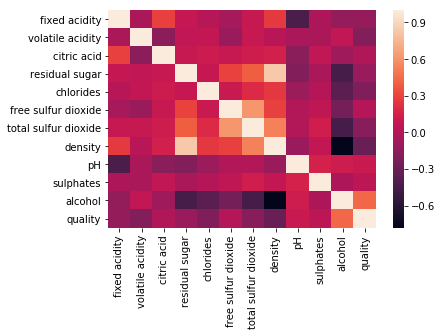

In [63]:
sns.heatmap(data.corr());

In [28]:
y = data['quality']
X = data.drop('quality', axis = 1)
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.33, random_state = 17)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Ваш код здесь
X_holdout_scaled = scaler.transform(X_holdout) # Ваш код здесь

In [32]:
X_train.shape, X_holdout.shape, y_train.shape

((3281, 11), (1617, 11), (3281,))

## Линейная регрессия

**Обучите простую линейную регрессию.**

In [34]:
linreg = LinearRegression(normalize=True)
linreg.fit(X_train_scaled,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

**<font color='red'>Вопрос 1:</font> Каковы среднеквадратичные ошибки линейной регрессии на обучающей и отложенной выборках?**

In [39]:

print("Mean squared error (train): %.3f" % mean_squared_error(y_train, linreg.predict(X_train_scaled)))
print("Mean squared error (test): %.3f" % mean_squared_error(y_holdout, linreg.predict(X_holdout_scaled)))

Mean squared error (train): 0.557
Mean squared error (test): 0.584


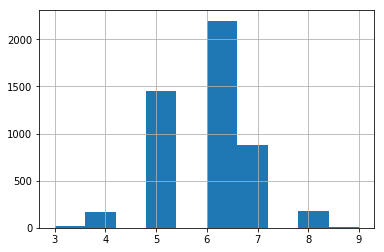

In [43]:
data['quality'].hist();


**Посмотрите на коэффициенты модели и отранжируйте признаки по влиянию на качество вина (учтите, что большие по модулю отрицательные значения коэффициентов тоже говорят о сильном влиянии). Создайте для этого новый небольшой DataFrame.**<br>
**<font color='red'>Вопрос 2:</font> Какой признак линейная регрессия считает наиболее сильно влияющим на качество вина?**

In [51]:
linreg_coef = pd.DataFrame(linreg.coef_,data.columns[:-1], columns = ['coeff'])
linreg_coef.sort_values(by = 'coeff', ascending=False)

,coeff
residual sugar,0.530524
pH,0.151654
alcohol,0.135830
fixed acidity,0.100399
sulphates,0.060756
free sulfur dioxide,0.042835
total sulfur dioxide,0.012589
chlorides,0.009650
citric acid,-0.000093
volatile acidity,-0.188841


## Lasso-регрессия

**Обучите Lasso-регрессию с небольшим коэффициентом $\alpha = 0.01$ (слабая регуляризация). Пусть опять random_state=17.**

In [57]:
lasso1 = Lasso(alpha=0.01, random_state=17)
lasso1.fit(X_train_scaled, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=17,
   selection='cyclic', tol=0.0001, warm_start=False)

**Посмотрите на коэффициенты модели и отранжируйте признаки по влиянию на качество вина. Какой признак "отвалился" первым, то есть наименее важен для объяснения целевого признака в модели Lasso?**

In [59]:
lasso1_coef = pd.DataFrame(lasso1.coef_,data.columns[:-1], columns = ['coeff'])
lasso1_coef.sort_values(by = 'coeff', ascending = False)

,coeff
alcohol,0.332523
residual sugar,0.243653
pH,0.067612
free sulfur dioxide,0.042843
sulphates,0.027532
fixed acidity,-0.000000
citric acid,-0.000000
total sulfur dioxide,-0.000000
chlorides,-0.001819
volatile acidity,-0.185014


**Теперь определите лучшее значение $\alpha$ в процессе кросс-валидации 5-кратной кросс-валидации. Используйте LassoCV и random_state=17.**

In [65]:
alphas = np.logspace(-6, 2, 200)
lasso_cv = LassoCV(alphas=alphas, cv = 5, random_state=17)
lasso_cv.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.00000e-06, 1.09699e-06, ..., 9.11589e+01, 1.00000e+02]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=17, selection='cyclic', tol=0.0001,
    verbose=False)

In [72]:
lasso_cv.alpha_

0.0007842822061337682

In [91]:
lasso1 = Lasso(alpha=0.0007842822061337682, random_state=17)
lasso1.fit(X_train_scaled, y_train)
lasso1_coef = pd.DataFrame(lasso1.coef_,data.columns[:-1], columns = ['coeff'])
lasso1_coef.sort_values(by = 'coeff', ascending = False)

,coeff
residual sugar,0.498024
alcohol,0.157803
pH,0.141624
fixed acidity,0.087378
sulphates,0.057556
free sulfur dioxide,0.044429
total sulfur dioxide,0.008651
chlorides,0.006298
citric acid,0.000000
volatile acidity,-0.188277


**Выведите коэффициенты "лучшего" Lasso в порядке убывания влияния на качество вина. **<br>
**<font color='red'>Вопрос 3:</font> Какой признак "обнулился первым" в настроенной модели LASSO?**

In [ ]:
lasso_cv_coef = pd.DataFrame # Ваш код здесь
lasso_cv_coef.sort_values # Ваш код здесь

**Оцените среднеквадратичную ошибку модели на обучающей и тестовой выборках.**<br>
**<font color='red'>Вопрос 4:</font> Каковы среднеквадратичные ошибки настроенной LASSO-регрессии на обучающей и отложенной выборках?**

In [75]:
print("Mean squared error (train): %.3f" % mean_squared_error(y_train, lasso1.predict(X_train_scaled)))
print("Mean squared error (test): %.3f" % mean_squared_error(y_holdout, lasso1.predict(X_holdout_scaled)))

Mean squared error (train): 0.557
Mean squared error (test): 0.582


## Случайный лес

**Обучите случайный лес с параметрами "из коробки", фиксируя только random_state=17.**

In [77]:
forest = RandomForestRegressor(random_state=17)
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=17, verbose=0, warm_start=False)

**<font color='red'>Вопрос 5:</font> Каковы среднеквадратичные ошибки случайного леса на обучающей выборке, на кросс-валидации (cross_val_score с scoring='neg_mean_squared_error' и остальными параметрами по умолчанию) и на отложенной выборке?**

In [98]:
print("Mean squared error (train): %.3f" % mean_squared_error(y_train, forest.predict(X_train)))
# print("Mean squared error (cv): %.3f" % mean_squared_error(cv))
print("Mean squared error (test): %.3f" % mean_squared_error(y_holdout, forest.predict(X_holdout)))


Mean squared error (train): 0.120
Mean squared error (test): 0.425


**Настройте параметры min_samples_leaf и max_depth с помощью GridSearchCV и опять проверьте качество модели на кросс-валидации и на отложенной выборке.**

In [83]:
forest_params = {'max_depth': list(range(10, 25)), 
                 'min_samples_leaf': list(range(1, 8)),
                 'max_features': list(range(6,12))}

locally_best_forest = GridSearchCV(forest, forest_params,n_jobs=-1)
locally_best_forest.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7], 'max_features': [6, 7, 8, 9, 10, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [84]:
locally_best_forest.best_params_, locally_best_forest.best_score_

({'max_depth': 20, 'max_features': 6, 'min_samples_leaf': 2},
 0.3970390670120009)

**К сожалению, результаты  GridSearchCV не полностью воспроизводимы (могут отличаться на разных платформах даже при фиксировании *random_state*). Поэтому обучите лес с параметрами max_depth=19, max_features=7, и min_samples_leaf=1 (лучшие в моем случае).**<br>
**<font color='red'>Вопрос 6:</font> Каковы среднеквадратичные ошибки настроенного случайного леса на обучающей выборке, на кросс-валидации (cross_val_score с scoring='neg_mean_squared_error') и на отложенной выборке?**

In [87]:
forest = RandomForestRegressor(max_depth=19, max_features=7, min_samples_leaf=2, random_state=17)
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=19,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=17,
           verbose=0, warm_start=False)

In [88]:
# print("Mean squared error (cv): %.3f" % # Ваш код здесь
print("Mean squared error (test): %.3f" % mean_squared_error(y_holdout, forest.predict(X_holdout)))

Mean squared error (test): 0.425


**Оцените важность признаков с помощью случайного леса.**<br>
**<font color='red'>Вопрос 7:</font> Какой признак оказался главным в настроенной модели случайного леса?**

In [93]:
rf_importance = pd.DataFrame(forest.feature_importances_, data.columns[:-1], columns = ['coeff'])
rf_importance.sort_values(by = 'coeff', ascending = False)

,coeff
alcohol,0.240133
volatile acidity,0.120441
free sulfur dioxide,0.112566
pH,0.077791
chlorides,0.068569
total sulfur dioxide,0.068490
residual sugar,0.067151
density,0.065576
fixed acidity,0.063822
citric acid,0.061447


**Сделайте выводы о качестве моделей и оценках влияния признаков на качество вина с помощью этих трех моделей.**

In [95]:
lol  = forest.predict(X_holdout)

5.886973205577672